In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from watertap3.truck_pipe_cost_functions import elevation,pipe_costing,truck_costing
import pprint

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.util.infeasible import *
from idaes.core.util.model_statistics import *

In [2]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_baseline_dwi_5Feb23.csv')

In [19]:
state_alpha = 'AL'

In [6]:
# Combined function for plot (same as below)
def plot_economy_of_scale(state_alpha,cluster_df):
    treatment_lcow = []
    well_field_yield = []
    well_field_lcow = []
    brine_lcow = []
    treatment_lcow_no_clustering = []
    brine_lcow_no_clustering = []

    # Iterate through each cluster and subcluster. Create list of well unique id
    for cluster in cluster_df.cluster_id.unique():
        temp_df = cluster_df[cluster_df['cluster_id']==cluster]
        # print(cluster)
        for well_id in str(temp_df['unique_site_ID'].values[0]).split(','):
            # print(well_id)
            # print(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
            treatment_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
            well_field_yield.append(bw_df[bw_df['unique_site_ID']==well_id]['well_yield'].values[0])
            brine_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['pipe_lcow'].values[0])
        
        well_field_lcow.append(temp_df['cluster_avg_well_field_lcow'].values[0])
        treatment_lcow_no_clustering.append(np.average(treatment_lcow, weights=well_field_yield))
        brine_lcow_no_clustering.append(np.average(brine_lcow, weights=well_field_yield))

    idx = cluster_df['cluster_lcow'].idxmin()
    
    fig, ax = plt.subplots()

    x = ['Well Field', 'Treatment \n(No Clustering)', 'Brine Disposal \n(No Clustering)', 'Transport', 'Total LCOW \n(Clustering)']

    # Well Field
    bottom = 0
    ax.bar( x = x[0], height = well_field_lcow[idx], bottom=bottom, color='blue',width=0.5)

    # Treatment
    bottom = bottom + well_field_lcow[idx]             
    ax.bar(x=x[1], height=treatment_lcow_no_clustering[idx], bottom = bottom, color='blue',width=0.5)
        
    # Brine
    bottom = bottom + treatment_lcow_no_clustering[idx]
    ax.bar(x= x[2], height= brine_lcow_no_clustering[idx], bottom= bottom, color='blue',width=0.5)

    # Total lcow if there was no cluster
    ax.axhline(y = bottom + brine_lcow_no_clustering[idx],xmin=0, xmax=0.55, linestyle = '--',color ='black')
    trans = ax.get_yaxis_transform()
    plt.text(0.5,bottom + brine_lcow_no_clustering[idx]+0.05,'LCOW \n(without clustering)',
            transform=trans,horizontalalignment='center')

    # Transport lcow in clustering
    bottom = bottom + brine_lcow_no_clustering[idx]
    ax.bar(x= x[3], height= (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx]),
                bottom = bottom, color='blue',width=0.5)

    # Total LCOW in clustering
    bottom = bottom + (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx])
    height = min(cluster_df['cluster_lcow'].values) - bottom

    ax.bar(x=x[4], height = height, bottom= bottom, color='green',width=0.5)

    ax.axhline(y = cluster_df['cluster_lcow'].values[idx], linestyle = '--',color ='black')
    trans = ax.get_yaxis_transform()
    plt.text(0.9,cluster_df['cluster_lcow'].values[idx]-0.2,'LCOW \n(with clustering)',transform=trans,horizontalalignment='center')

    ax.set_xticks(x,x,fontsize=8, rotation = 45)
    ax.set_ylabel('Average LCOW ($/m3 water treated)')
    ax.set_ylim([0,math.ceil(bottom)])

    ax.set_title(state_alpha)
    plt.ioff()
    return fig

In [3]:
# Combined function for unclustered optimization

def unclustered_opt_func(pp_state):
    
    # Sort the list use minimum tLCOW connections. Track well volume 

    # Create dictionary of wells
    well_site  = pp_state['BWSites'].unique()
    well_vol = (pp_state[pp_state['BWSites']==well]['BWAvailable'].unique()[0] for well in well_site)
    wells_unclustered = dict(zip(well_site,well_vol))

    # Create dictionary of powerplants
    pp_pc = pp_state['PlantCode'].unique()
    pp_demand = (pp_state[pp_state['PlantCode']==pp]['PPDemand'].unique()[0] for pp in pp_pc)
    pp_unclustered = dict(zip(pp_pc,pp_demand))

    # Sort the dataframe in increasing order of tLCOW
    pp_state_sorted = pp_state.sort_values(['tLCOW'],ignore_index=True)
    optimize_network = pd.DataFrame(columns = pp_state.columns.values)

    for idx,row in pp_state_sorted.iterrows():
        # Check if demand has already been met and if well is already exhausted
        if wells_unclustered[row['BWSites']]>0:
            if pp_unclustered[row['PlantCode']]>0:
                # Check if the demand is more than supply
                # Updating the BWAvailable values
                row['BWAvailable'] = wells_unclustered[row['BWSites']]
                optimize_network.loc[len(optimize_network)] = row
                # Update demand and well availability
                temp =  pp_unclustered[row['PlantCode']]
                pp_unclustered[row['PlantCode']] = pp_unclustered[row['PlantCode']] -  wells_unclustered[row['BWSites']]
                wells_unclustered[row['BWSites']] = wells_unclustered[row['BWSites']] - temp
                
    optimize_network1 = optimize_network.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
    optimize_network1 = optimize_network1.apply(pd.DataFrame).set_index('PlantCode')

    weighted_lcow = []
    cum_pp_demand_frac_met = []
    cum_bw_vol = []

    for pp in optimize_network1.index.unique():
        try:
            cum_bw_supply = np.array(optimize_network1['TransportVol_m3/s'].loc[pp].cumsum())
            cum_cost = np.array((optimize_network1['TransportVol_m3/s'].loc[pp]*optimize_network1['tLCOW'].loc[pp]).cumsum())
        except AttributeError:
            cum_bw_supply =  np.array([optimize_network1['TransportVol_m3/s'].loc[pp]])
            cum_cost = np.array((optimize_network1['TransportVol_m3/s'].loc[pp]*optimize_network1['tLCOW'].loc[pp]))

        temp = np.divide(cum_cost,cum_bw_supply)
        cum_bw_vol=np.append(cum_bw_vol,cum_bw_supply)
        weighted_lcow = np.append(weighted_lcow,temp,axis=0)
        temp_demand_met = cum_bw_supply/optimize_network1['PPDemand'].loc[pp]
        cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

    optimize_network1['WeightedtLCOW'] = weighted_lcow
    optimize_network1['Cum_Vol'] = cum_bw_vol
    optimize_network1['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
    optimize_network1['Cum_PPDemandFracMet'] = np.where(optimize_network1['Cum_PPDemandFracMet']>1,1,optimize_network1['Cum_PPDemandFracMet'])     

    optimize_network_unclustered = optimize_network1

    return optimize_network_unclustered

In [4]:
# Combined function for clustered optimization
def clustered_opt_func(pp_state_cluster):
    # For clustered dataframe

    # Create dictionary of clusters
    well_site  = pp_state_cluster['BWSites'].unique()
    well_vol = (pp_state_cluster[pp_state_cluster['BWSites']==well]['BWAvailable'].unique()[0] for well in well_site)
    wells_clustered = dict(zip(well_site,well_vol))

    # Create dictionary of powerplants
    pp_pc = pp_state_cluster['PlantCode'].unique()
    pp_demand = (pp_state_cluster[pp_state_cluster['PlantCode']==pp]['PPDemand'].unique()[0] for pp in pp_pc)
    pp_clustered = dict(zip(pp_pc,pp_demand))

    # pp_clustered
    # Sort the dataframe in increasing order of tLCOW
    pp_state_cluster_sorted = pp_state_cluster.sort_values(['tLCOW'],ignore_index=True)
    optimize_network = pd.DataFrame(columns = pp_state_cluster.columns.values)

    for idx,row in pp_state_cluster_sorted.iterrows():
        # Check if demand has already been met and if well is already exhausted
        if wells_clustered[row['BWSites']]>0:
            if pp_clustered[row['PlantCode']]>0:
    
                # Updating the BWAvailable values
                row['BWAvailable'] = wells_clustered[row['BWSites']]
                optimize_network.loc[len(optimize_network)] = row
                # Update demand and well availability
                temp =  pp_clustered[row['PlantCode']]
                pp_clustered[row['PlantCode']] = pp_clustered[row['PlantCode']] -  wells_clustered[row['BWSites']]
                wells_clustered[row['BWSites']] = wells_clustered[row['BWSites']] - temp

    optimize_network1 = optimize_network.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
    optimize_network1 = optimize_network1.apply(pd.DataFrame).set_index('PlantCode')
    # optimize_network1

    weighted_lcow = []
    cum_pp_demand_frac_met = []
    cum_bw_vol = []

    for pp in optimize_network1.index.unique():
        try:
            cum_bw_supply = np.array(optimize_network1['TransportVol_m3/s'].loc[pp].cumsum())
            cum_cost = np.array((optimize_network1['TransportVol_m3/s'].loc[pp]*optimize_network1['tLCOW'].loc[pp]).cumsum())
        except AttributeError:
            cum_bw_supply =  np.array([optimize_network1['TransportVol_m3/s'].loc[pp]])
            cum_cost = np.array((optimize_network1['TransportVol_m3/s'].loc[pp]*optimize_network1['tLCOW'].loc[pp]))

        temp = np.divide(cum_cost,cum_bw_supply)
        cum_bw_vol=np.append(cum_bw_vol,cum_bw_supply)
        weighted_lcow = np.append(weighted_lcow, temp,axis=0)
        temp_demand_met = cum_bw_supply/optimize_network1['PPDemand'].loc[pp]
        cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

    optimize_network1['WeightedtLCOW'] = weighted_lcow
    optimize_network1['Cum_Vol'] = cum_bw_vol
    optimize_network1['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
    optimize_network1['Cum_PPDemandFracMet'] = np.where(optimize_network1['Cum_PPDemandFracMet']>1,1,optimize_network1['Cum_PPDemandFracMet'])     

    optimize_network_clustered = optimize_network1
    return optimize_network_clustered

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Ind

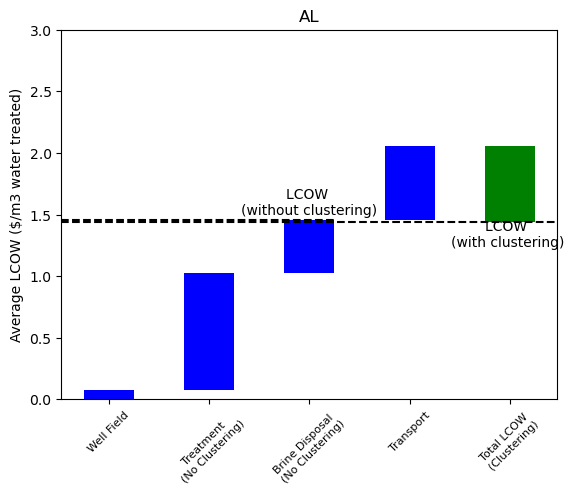

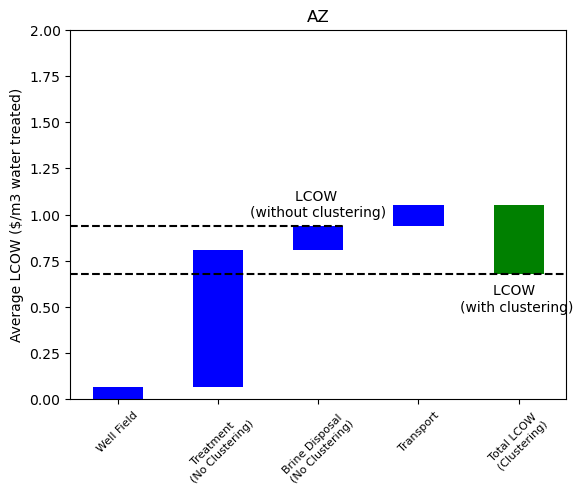

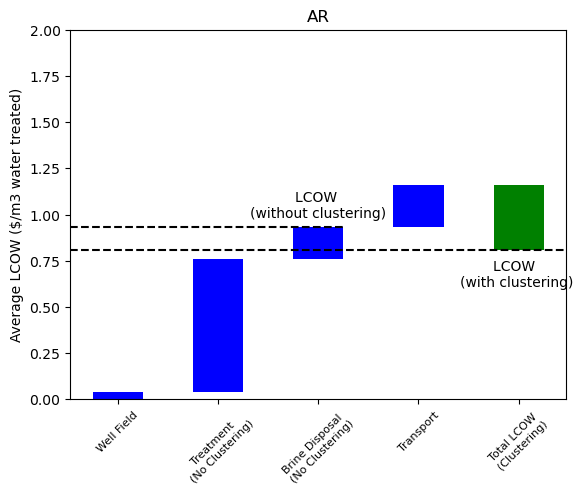

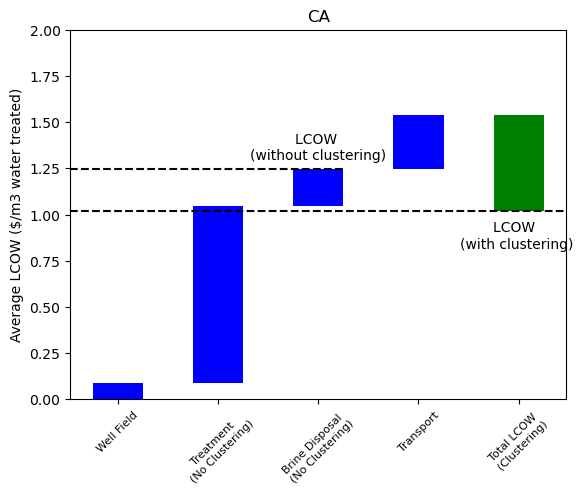

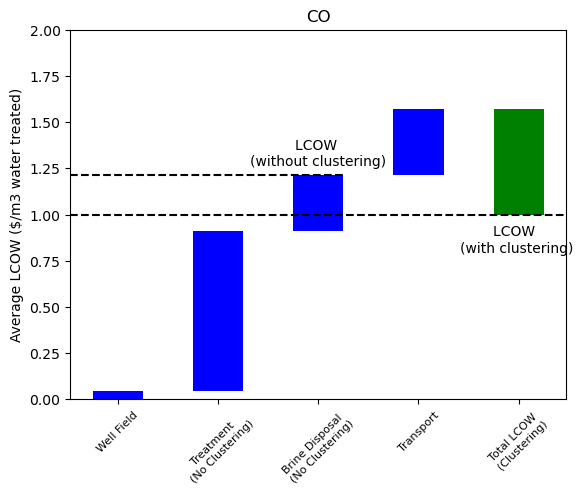

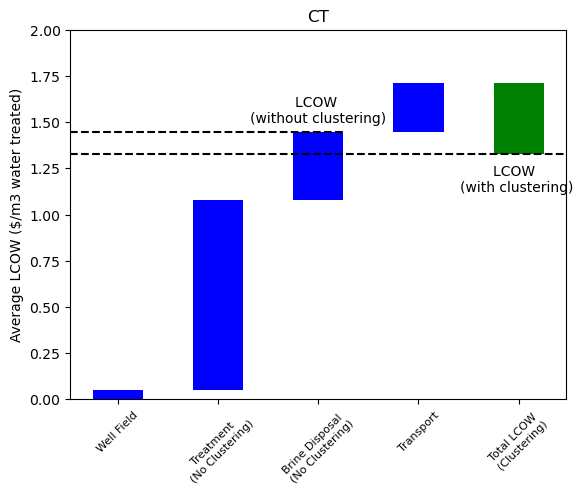

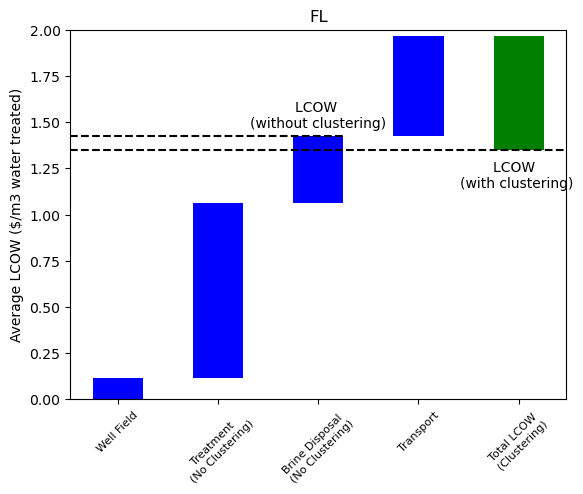

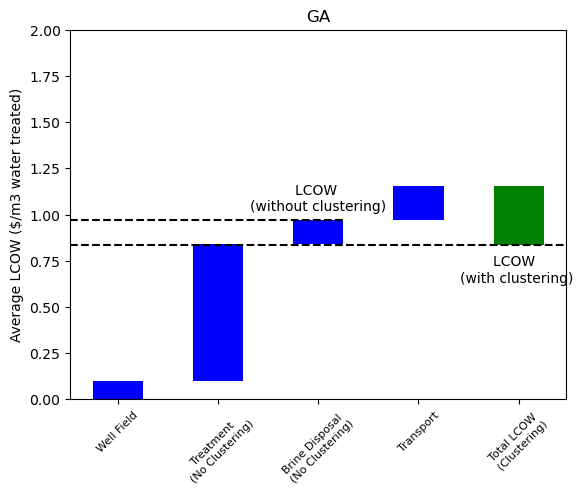

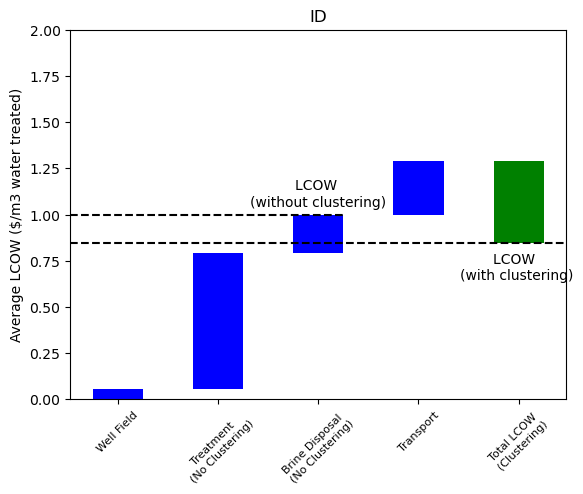

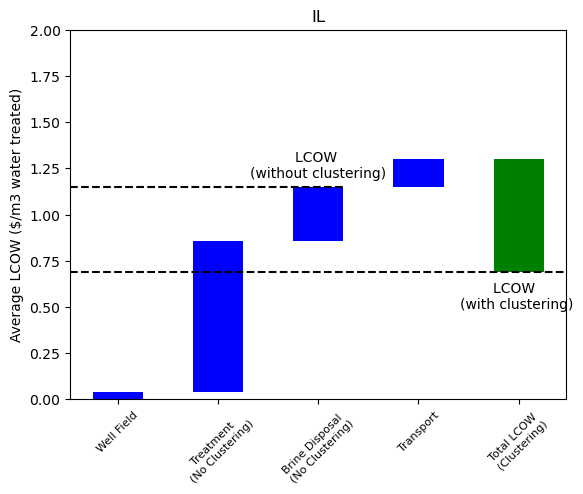

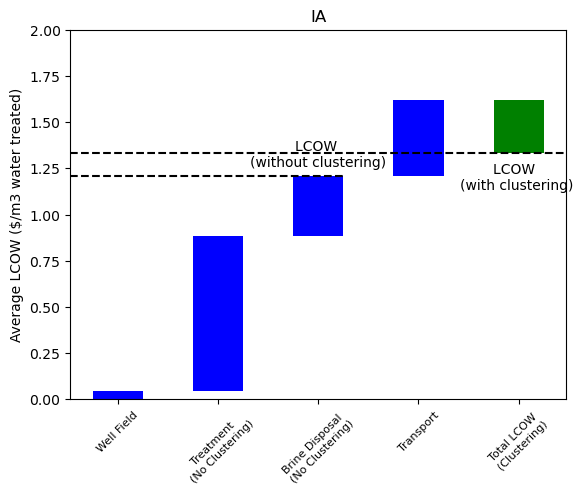

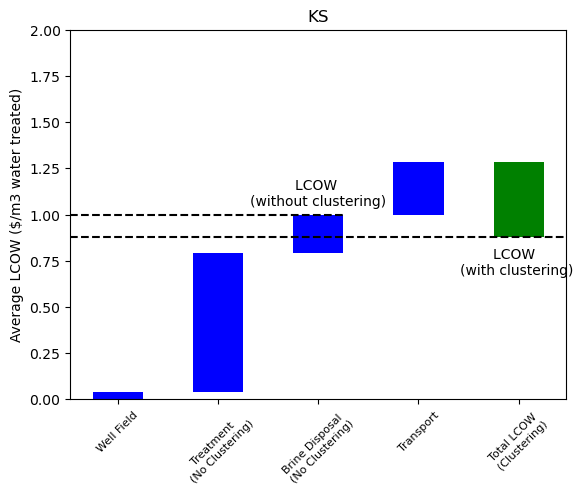

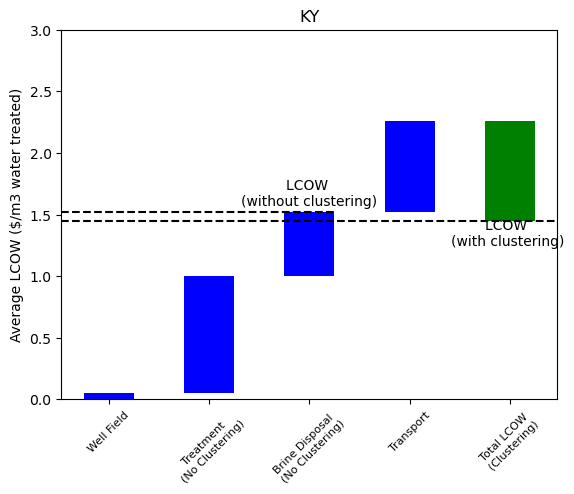

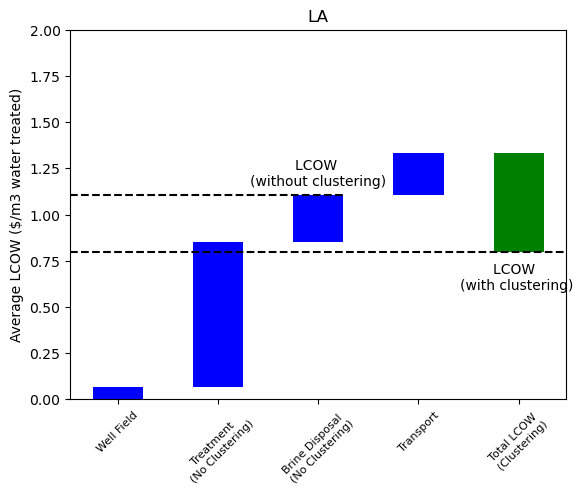

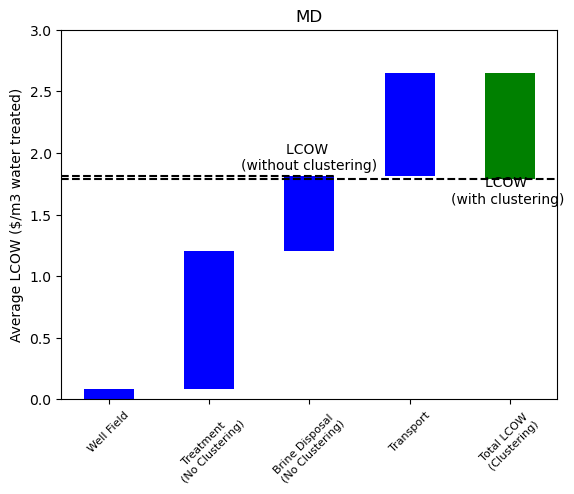

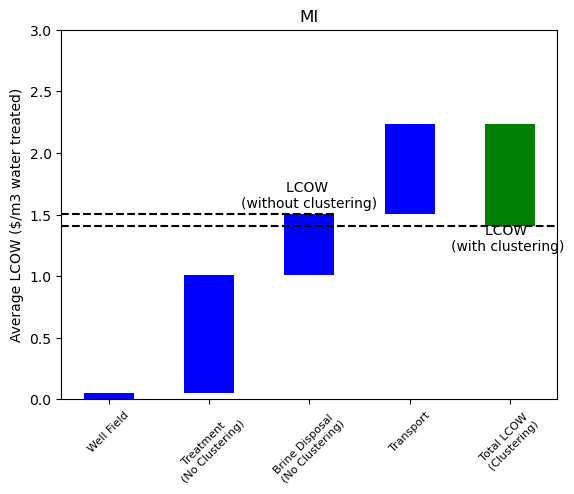

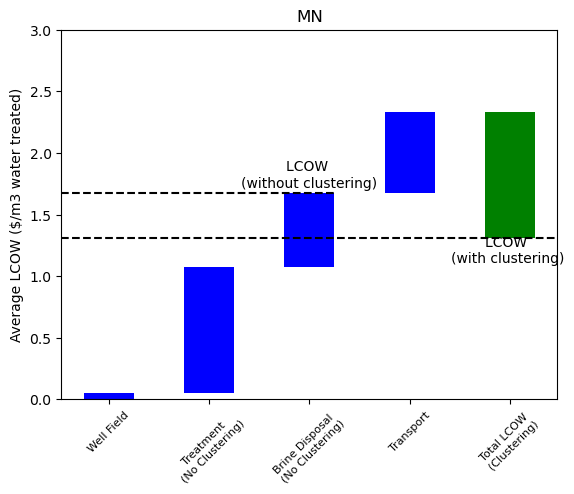

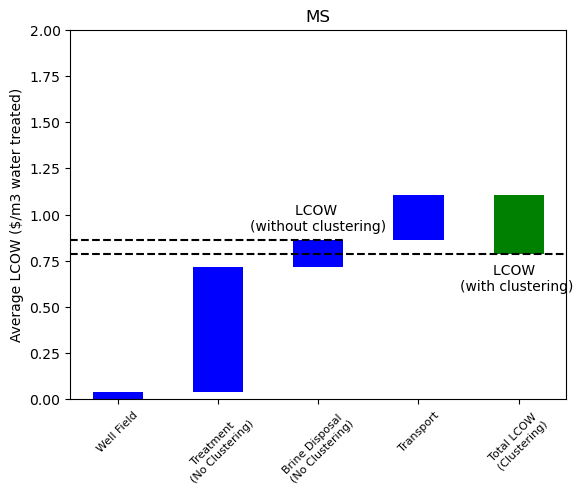

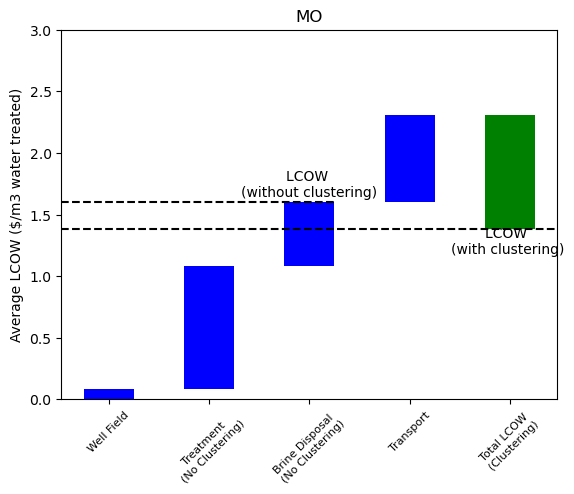

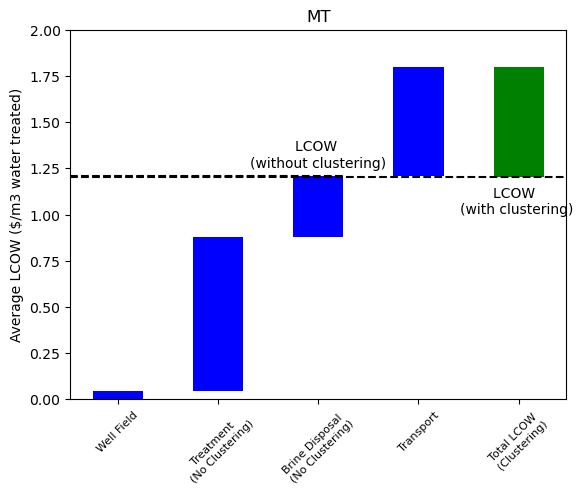

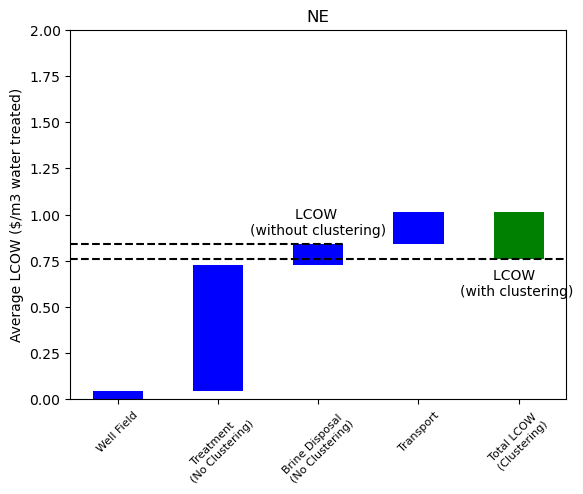

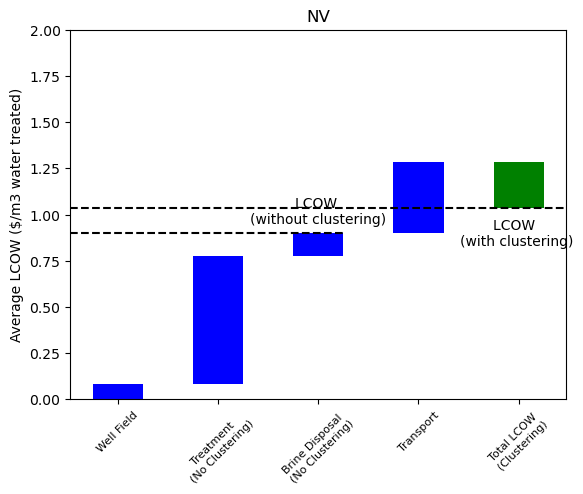

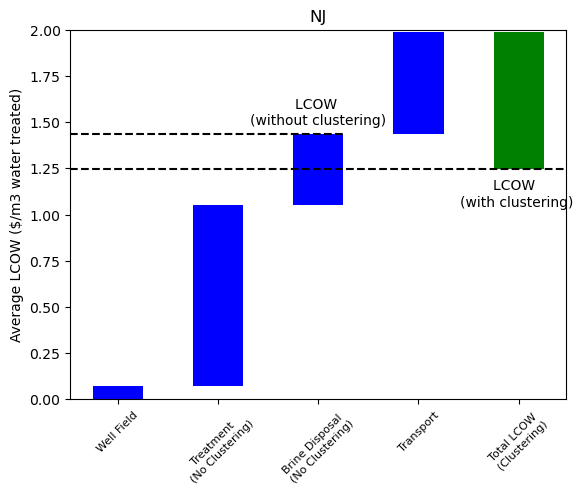

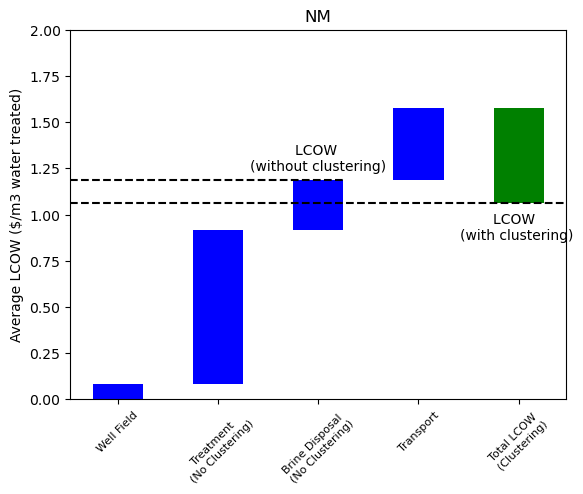

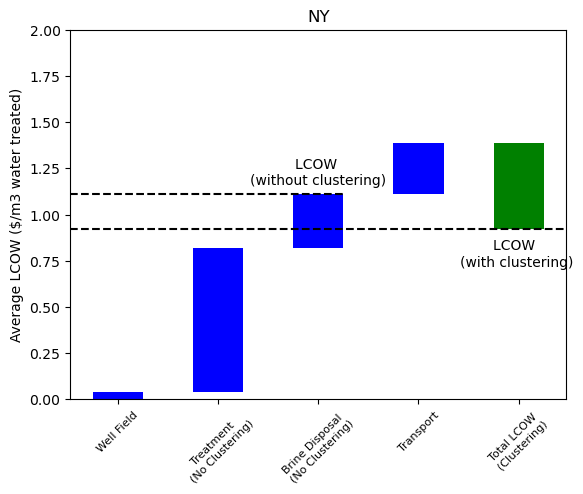

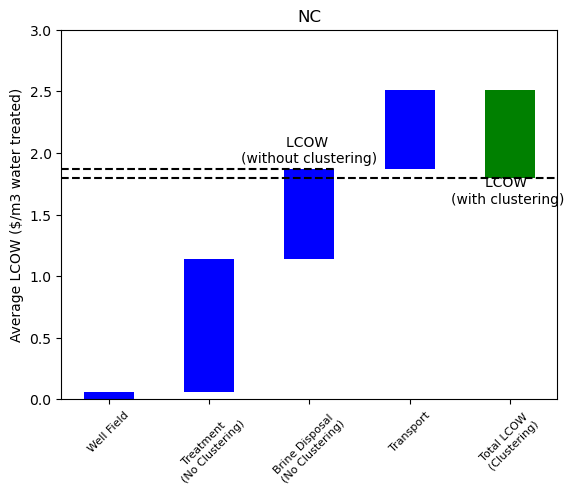

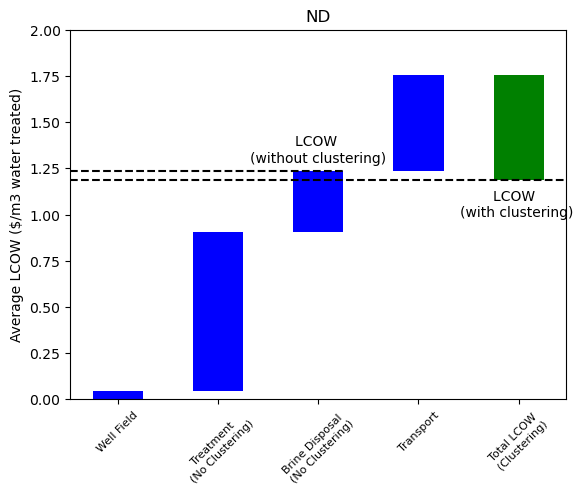

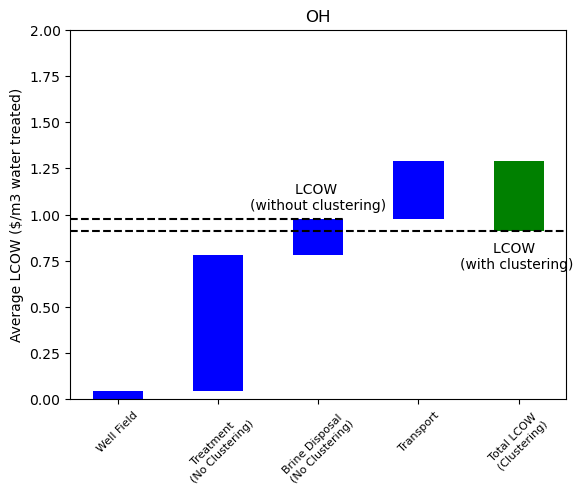

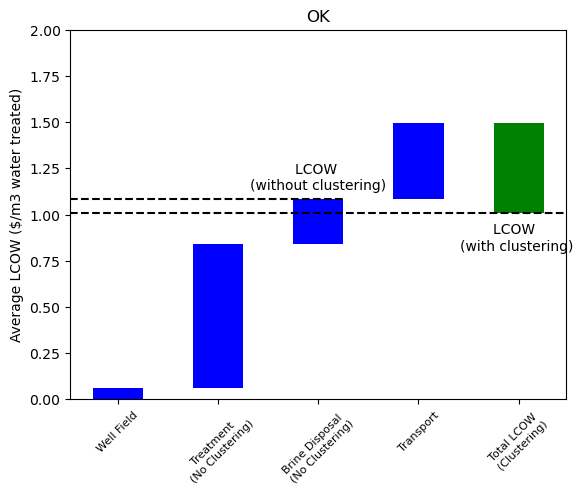

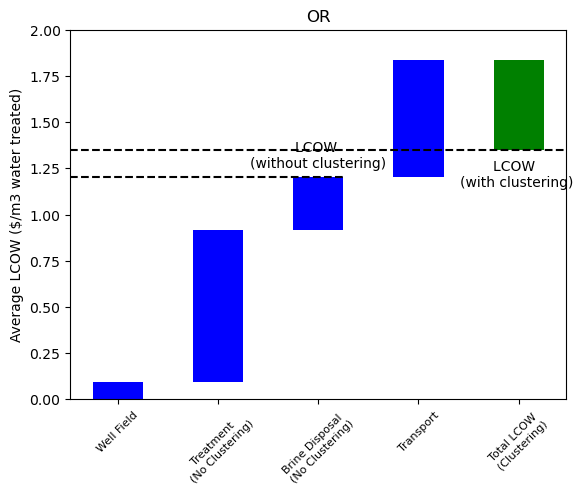

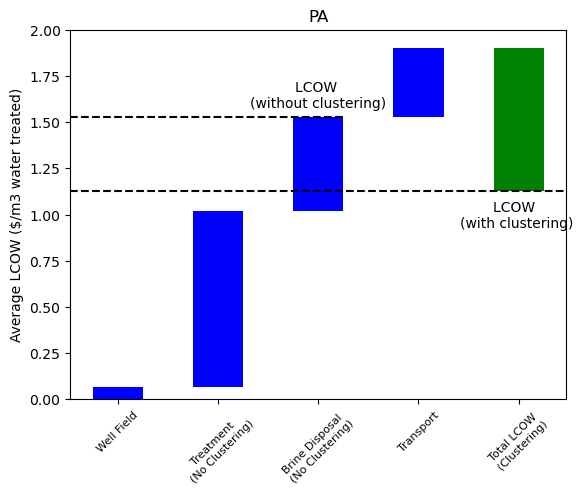

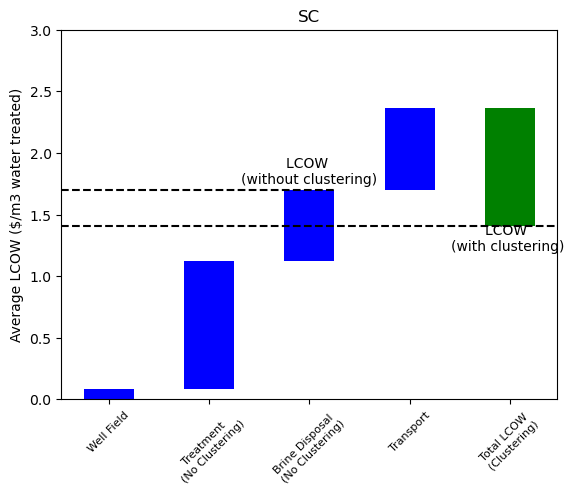

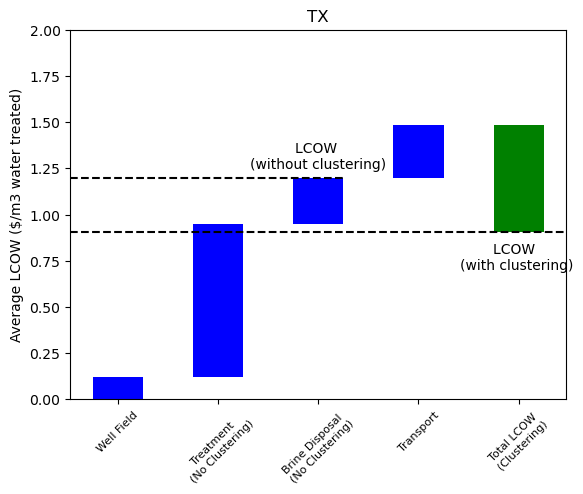

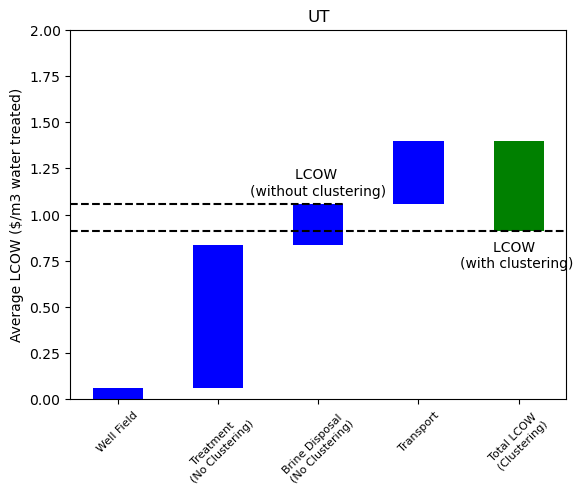

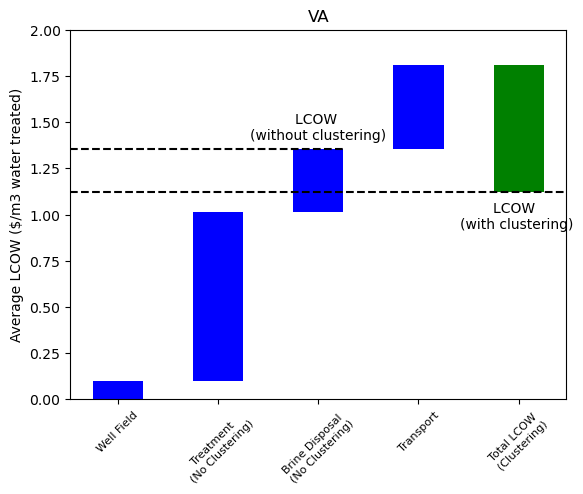

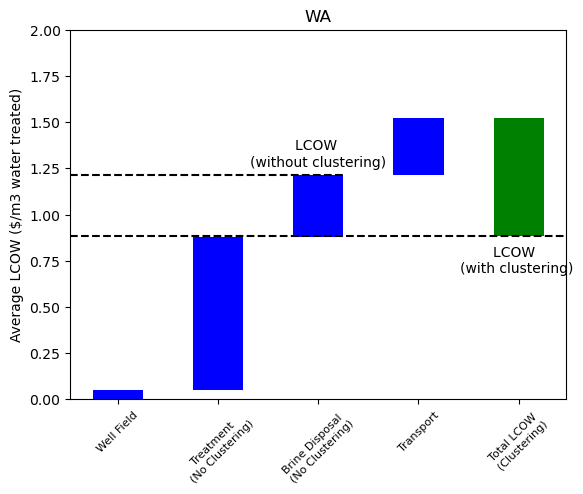

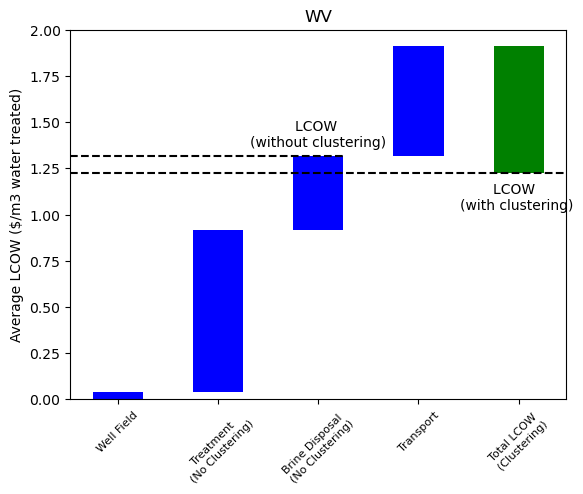

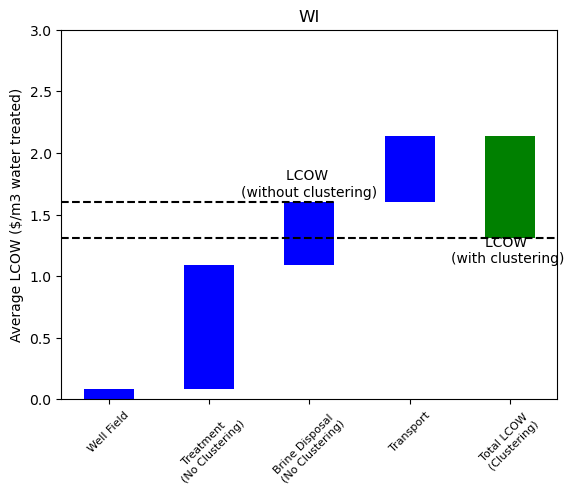

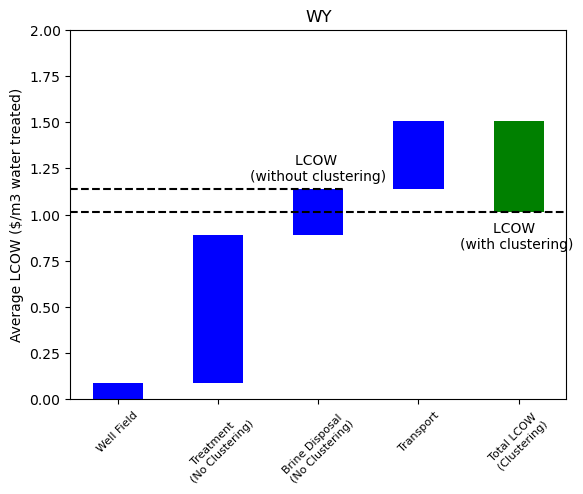

In [7]:
# Automating economy of scale calculation

state_codes = ['AL','AZ','AR','CA','CO','CT','FL','GA','ID','IL',
               'IA','KS','KY','LA','MD','MI','MN','MS','MO',
               'MT','NE','NV','NJ','NM','NY','NC','ND','OH',
               'OK','OR','PA','SC','TX','UT','VA','WA',
               'WV','WI','WY']

# Create lists for results

transport_lcow_unclustered_list = []
treatment_lcow_unclustered_list = []
transport_lcow_clustered_list = []
treatment_lcow_clustered_list = []

for state_alpha in state_codes:
    # Read relevant files
    PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\clustering_results\\' + state_alpha
    cluster_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

    fig = plot_economy_of_scale(state_alpha,cluster_df)
    PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha + '\\'
    fig.savefig(PATH +  state_alpha.lower()+'_economy_of_scale.jpg')

    # LCOW calculations section
    pp_combined = pd.read_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha + '\pp_combined_unclustered_v2_' + state_alpha.lower()+'.csv')
    pp_state = pp_combined[pp_combined['State']==state_alpha]
    bw_state = bw_df[bw_df['state_alpha']==state_alpha]

    # Read clustered table
    pp_combined_cluster = pd.read_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha + '\pp_combined_clustered_v2_'+ state_alpha.lower()+'.csv')
    pp_state_cluster = pp_combined_cluster[pp_combined_cluster['State']==state_alpha]

    # PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\clustering_results\\' + state_alpha
    # cluster_bw_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

    # Unclustered case calculation
    optimize_network_unclustered = unclustered_opt_func(pp_state)
    # Save optimized dataframe
    optimize_network_unclustered.to_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + 
                                        state_alpha + '\pp_unclustered_optimized_network_v2_' + state_alpha.lower()+'.csv')

    transport_lcow_unclustered = 0
    treatment_lcow_unclustered = 0

    vol = 0
    temp = 0 

    for idx,row in optimize_network_unclustered.iterrows():
        transport_lcow_unclustered = transport_lcow_unclustered + row['TransportVol_m3/s']*row['TransportLCOW']
        treatment_lcow_unclustered = treatment_lcow_unclustered + row['TransportVol_m3/s']*row['LCOW']

        vol = vol + row['TransportVol_m3/s']

    transport_lcow_unclustered = transport_lcow_unclustered/vol
    treatment_lcow_unclustered = treatment_lcow_unclustered/vol    

    transport_lcow_unclustered_list.append(transport_lcow_unclustered)
    treatment_lcow_unclustered_list.append(treatment_lcow_unclustered)

    # Clustered case calculations
    optimize_network_clustered = clustered_opt_func(pp_state_cluster)
    # Save optimized dataframe
    optimize_network_clustered.to_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + 
                                      state_alpha + '\pp_clustered_optimized_network_v2_' + state_alpha.lower()+'.csv')

    transport_lcow_clustered = 0
    treatment_lcow_clustered = 0

    vol = 0
    temp = 0 

    for idx,row in optimize_network_clustered.iterrows():
        transport_lcow_clustered = transport_lcow_clustered + row['TransportVol_m3/s']*row['TransportLCOW']
        treatment_lcow_clustered = treatment_lcow_clustered + row['TransportVol_m3/s']*row['LCOW']

        vol = vol + row['TransportVol_m3/s']

    transport_lcow_clustered = transport_lcow_clustered/vol
    treatment_lcow_clustered = treatment_lcow_clustered/vol   

    transport_lcow_clustered_list.append(transport_lcow_clustered)
    treatment_lcow_clustered_list.append(treatment_lcow_clustered)


In [9]:
results_df = pd.DataFrame(columns=['state_alpha','transport_lcow_unclustered','treatment_lcow_unclustered',
                                   'transport_lcow_clustered','treatment_lcow_clustered'])
results_df['state_alpha'] = state_codes
results_df['transport_lcow_unclustered'] = transport_lcow_unclustered_list
results_df['treatment_lcow_unclustered'] = treatment_lcow_unclustered_list
results_df['transport_lcow_clustered'] = transport_lcow_clustered_list
results_df['treatment_lcow_clustered'] = treatment_lcow_clustered_list

results_df.head(5)
results_df.to_csv(r'C:\Users\mhardika\Documents\AMO\Analysis Data Files\Power\power_rough_economy_of_scale_output_v2.csv')

Single State Code

In [9]:
# Read the lcow file and the cluster lcow file

# Brackish water USGS files
# bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
# PATH = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\clustering_results\\' + state_alpha

PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\clustering_results\\' + state_alpha
cluster_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

In [10]:
idx = cluster_df['cluster_lcow'].idxmin()
idx

0

In [8]:
# Get individual well treatment lcow
treatment_lcow = []
well_field_yield = []
well_field_lcow = []
brine_lcow = []
treatment_lcow_no_clustering = []
brine_lcow_no_clustering = []

# Iterate through each cluster and subcluster. Create list of well unique id
for cluster in cluster_df.cluster_id.unique():
    temp_df = cluster_df[cluster_df['cluster_id']==cluster]
    # print(cluster)
    for well_id in str(temp_df['unique_site_ID'].values[0]).split(','):
        # print(well_id)
        # print(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
        treatment_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
        well_field_yield.append(bw_df[bw_df['unique_site_ID']==well_id]['well_yield'].values[0])
        brine_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['pipe_lcow'].values[0])
    
    well_field_lcow.append(temp_df['cluster_avg_well_field_lcow'].values[0])
    treatment_lcow_no_clustering.append(np.average(treatment_lcow, weights=well_field_yield))
    brine_lcow_no_clustering.append(np.average(brine_lcow, weights=well_field_yield))

print(treatment_lcow_no_clustering)
print(well_field_lcow)
print(brine_lcow_no_clustering)

print('Clustered LCOW')
print(cluster_df['cluster_lcow'].values)


[0.8015046822373575, 0.8100618526147733, 0.9153154522921993]
[0.0887488923953445, 0.0792828073267256, 0.3492309503015198]
[0.24586917538364098, 0.2563834098155861, 0.23882637148067135]
Clustered LCOW
[1.01534038 1.05039866 1.26353408]


Text(0.5, 1.0, 'AL')

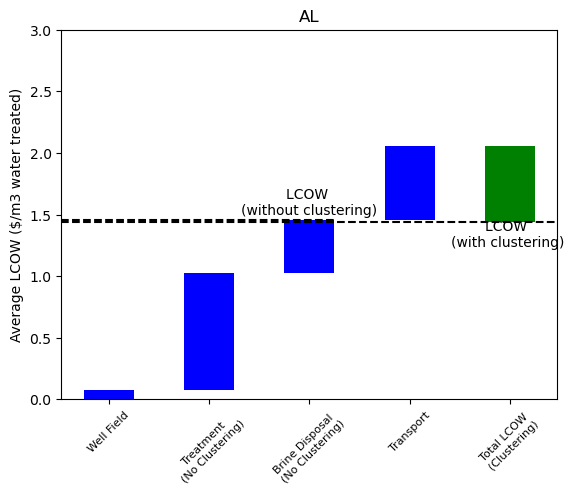

In [12]:
fig, ax = plt.subplots()

x = ['Well Field', 'Treatment \n(No Clustering)', 'Brine Disposal \n(No Clustering)', 'Transport', 'Total LCOW \n(Clustering)']

# Well Field
bottom = 0
ax.bar( x = x[0], height = well_field_lcow[idx], bottom=bottom, color='blue',width=0.5)

# Treatment
bottom = bottom + well_field_lcow[idx]             
ax.bar(x=x[1], height=treatment_lcow_no_clustering[idx], bottom = bottom, color='blue',width=0.5)
       
# Brine
bottom = bottom + treatment_lcow_no_clustering[idx]
ax.bar(x= x[2], height= brine_lcow_no_clustering[idx], bottom= bottom, color='blue',width=0.5)

# Total lcow if there was no cluster
ax.axhline(y = bottom + brine_lcow_no_clustering[idx],xmin=0, xmax=0.55, linestyle = '--',color ='black')
trans = ax.get_yaxis_transform()
plt.text(0.5,bottom + brine_lcow_no_clustering[idx]+0.05,'LCOW \n(without clustering)',
         transform=trans,horizontalalignment='center')

# Transport lcow in clustering
bottom = bottom + brine_lcow_no_clustering[idx]
ax.bar(x= x[3], height= (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx]),
            bottom = bottom, color='blue',width=0.5)

# Total LCOW in clustering
bottom = bottom + (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx])
height = min(cluster_df['cluster_lcow'].values) - bottom

ax.bar(x=x[4], height = height, bottom= bottom, color='green',width=0.5)

ax.axhline(y = cluster_df['cluster_lcow'].values[idx], linestyle = '--',color ='black')
trans = ax.get_yaxis_transform()
plt.text(0.9,cluster_df['cluster_lcow'].values[idx]-0.2,'LCOW \n(with clustering)',transform=trans,horizontalalignment='center')

ax.set_xticks(x,x,fontsize=8, rotation = 45)
ax.set_ylabel('Average LCOW ($/m3 water treated)')
ax.set_ylim([0,math.ceil(bottom)])

ax.set_title(state_alpha)

In [1185]:
PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha + '\\'
fig.savefig(PATH +  state_alpha.lower()+'_economy_of_scale.jpg')

In [1186]:
# Economy of scale including transport cost to the powerplant sector

In [1187]:
# Trying optimization with Pyomo again
# 2 scenarios:
# 1. Total demand > BW available - Remove sum 1 constraint?
# 2. Total demand < BW available - This is straightforward

In [1188]:
# Create matrix of brackish water sites (rows) and powerplant (columns) distance
from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.util.infeasible import *
from idaes.core.util.model_statistics import *

In [8]:
# Check if demand or supply is greater
state_alpha = 'AL'
# pp_combined = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\pp_combined_unclustered_' + state_alpha.lower()+'.csv')
pp_combined = pd.read_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha + '\pp_combined_unclustered_' + state_alpha.lower()+'.csv')
pp_state = pp_combined[pp_combined['State']==state_alpha]
bw_state = bw_df[bw_df['state_alpha']==state_alpha]

print('Total well yield:', bw_state['well_yield'].sum())
print('Total demand:', pp_state['PPDemand'].unique().sum())

Total well yield: 0.28838530399999995
Total demand: 324.53552367264183


In [9]:
# Read clustered table

# pp_combined_cluster = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\pp_combined_clustered_'+state_alpha.lower()+'.csv')
pp_combined_cluster = pd.read_csv(r'\Users\mhardika\Documents\AMO\Analysis Data Files\Power\\' + state_alpha + '\pp_combined_clustered_'+ state_alpha.lower()+'.csv')
pp_state_cluster = pp_combined_cluster[pp_combined_cluster['State']==state_alpha]

PATH = r'\Users\mhardika\Documents\AMO\Analysis Data Files\clustering_results\\' + state_alpha
cluster_bw_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

In [10]:
# Assuming scenario 2 where demand > supply
# Sort the list use minimum tLCOW connections. Track well volume 

# Create dictionary of wells
well_site  = pp_state['BWSites'].unique()
well_vol = (pp_state[pp_state['BWSites']==well]['BWAvailable'].unique()[0] for well in well_site)
wells_unclustered = dict(zip(well_site,well_vol))

# Create dictionary of powerplants
pp_pc = pp_state['PlantCode'].unique()
pp_demand = (pp_state[pp_state['PlantCode']==pp]['PPDemand'].unique()[0] for pp in pp_pc)
pp_unclustered = dict(zip(pp_pc,pp_demand))

# Sort the datafram in increasing order of tLCOW
pp_state_sorted = pp_state.sort_values(['tLCOW'],ignore_index=True)
optimize_network = pd.DataFrame(columns = pp_state.columns.values)

for idx,row in pp_state_sorted.iterrows():
    # Check if demand has already been met and if well is already exhausted
    if wells_unclustered[row['BWSites']]>0:
        if pp_unclustered[row['PlantCode']]>0:
            optimize_network.loc[len(optimize_network)] = row
            # Update demand and well availability
            temp =  pp_unclustered[row['PlantCode']]
            pp_unclustered[row['PlantCode']] = pp_unclustered[row['PlantCode']] -  wells_unclustered[row['BWSites']]
            wells_unclustered[row['BWSites']] = wells_unclustered[row['BWSites']] - temp

optimize_network1 = optimize_network.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
optimize_network1 = optimize_network1.apply(pd.DataFrame).set_index('PlantCode')

weighted_lcow = []
cum_pp_demand_frac_met = []
cum_bw_vol = []

for pp in optimize_network1.index.unique():
    try:
        cum_bw_available = np.array(optimize_network1['BWAvailable'].loc[pp].cumsum())
        cum_cost = np.array((optimize_network1['BWAvailable'].loc[pp]*optimize_network1['tLCOW'].loc[pp]).cumsum())
    except AttributeError:
        cum_bw_available =  np.array([optimize_network1['BWAvailable'].loc[pp]])
        cum_cost = np.array((optimize_network1['BWAvailable'].loc[pp]*optimize_network1['tLCOW'].loc[pp]))

    temp = np.divide(cum_cost,cum_bw_available)
    cum_bw_vol=np.append(cum_bw_vol,cum_bw_available)
    weighted_lcow = np.append(weighted_lcow,temp,axis=0)
    temp_demand_met = cum_bw_available/optimize_network1['PPDemand'].loc[pp]
    cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

optimize_network1['WeightedtLCOW'] = weighted_lcow
optimize_network1['Cum_Vol'] = cum_bw_vol
optimize_network1['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
optimize_network1['Cum_PPDemandFracMet'] = np.where(optimize_network1['Cum_PPDemandFracMet']>1,1,optimize_network1['Cum_PPDemandFracMet'])     

optimize_network_unclustered = optimize_network1
optimize_network_unclustered

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,State,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet,PPElevation,BWElevation,Cum_Vol
PlantCode,,,,,,,,,,,,,,,,,,
3,AL,31.0069,-88.0103,57.648886,FETH-304300N0880100.1,30.716667,-88.016694,0.016167,32.278286,0.00028,2.02359,1.384777,3.408367,3.408367,0.00028,6.572838,0.572287,0.016167
3,AL,31.0069,-88.0103,57.648886,USGS-301514088071701,30.254093,-88.121391,0.01356,84.38054,0.000235,2.198158,2.679365,4.877522,4.078535,0.000516,6.572838,0.922551,0.029727
10,AL,32.6017,-87.7811,32.119974,USGS-323012087492701,32.503471,-87.824181,0.032926,11.644975,0.001025,1.458685,0.565537,2.024223,2.024223,0.001025,31.777483,48.823505,0.032926
10,AL,32.6017,-87.7811,32.119974,FETH-320300N0873200.1,32.05,-87.533361,0.016246,65.61426,0.000506,2.072464,1.975777,4.048241,2.692944,0.001531,31.777483,43.870712,0.049172
56,AL,31.48802,-87.9107,0.299901,USGS-315412087443401,31.902098,-87.742783,0.016139,48.707128,0.053816,2.093877,1.694242,3.78812,3.78812,0.053816,13.374519,112.382591,0.016139
533,AL,31.40026,-86.4764,0.166917,USGS-311930086272501,31.32517,-86.456902,0.044227,8.552368,0.264964,1.316746,0.426046,1.742791,1.742791,0.264964,74.249077,104.84388,0.044227
533,AL,31.40026,-86.4764,0.166917,USGS-310153085514501,31.031568,-85.862434,0.029304,71.341448,0.175558,1.552535,1.357244,2.90978,2.207863,0.440523,74.249077,28.621227,0.073531
6002,AL,33.6319,-87.0597,1.77714,FETH-332800N0865900.1,33.466667,-86.983361,0.056949,19.688047,0.032045,1.201758,0.447455,1.649213,1.649213,0.032045,92.802856,185.24765,0.056949
6002,AL,33.6319,-87.0597,1.77714,FETH-333800N0865900.1,33.633333,-86.983361,0.039767,7.069382,0.022377,1.310977,0.439272,1.750249,1.690756,0.054422,92.802856,135.401932,0.096716


In [11]:
# Calculate weight tLCOW for the state for unclustered scenario

lcow_uncluster = 0 
vol = 0
temp = 0 

for pp in optimize_network_unclustered.index.unique():
    try:
        temp = temp + optimize_network_unclustered.loc[pp]['WeightedtLCOW'].values[-1]*optimize_network_unclustered.loc[pp]['Cum_Vol'].values[-1]
        vol = vol + optimize_network_unclustered.loc[pp]['Cum_Vol'].values[-1]
    except:
        temp = temp + optimize_network_unclustered.loc[pp]['WeightedtLCOW']*optimize_network_unclustered.loc[pp]['Cum_Vol']
        vol = vol + optimize_network_unclustered.loc[pp]['Cum_Vol']


lcow_uncluster = temp/vol
lcow_uncluster

print(lcow_uncluster)

2.415013092435219


In [12]:
transport_lcow_unclustered = 0
treatment_lcow_unclustered = 0
vol = 0
temp = 0 

for idx,row in optimize_network_unclustered.iterrows():
    transport_lcow_unclustered = transport_lcow_unclustered + row['BWAvailable']*row['TransportLCOW']
    treatment_lcow_unclustered = treatment_lcow_unclustered + row['BWAvailable']*row['LCOW']

    vol = vol + row['BWAvailable']

transport_lcow_unclustered = transport_lcow_unclustered/vol
treatment_lcow_unclustered = treatment_lcow_unclustered/vol    

print('Unclustered')
print('Transport:',transport_lcow_unclustered)
print('Treatment:',treatment_lcow_unclustered)

Unclustered
Transport: 0.8984650846591049
Treatment: 1.5165480077761138


In [15]:
# For clustered dataframe

# Create dictionary of clusters
well_site  = pp_state_cluster['BWSites'].unique()
well_vol = (pp_state_cluster[pp_state_cluster['BWSites']==well]['BWAvailable'].unique()[0] for well in well_site)
wells_clustered = dict(zip(well_site,well_vol))

# Create dictionary of powerplants
pp_pc = pp_state_cluster['PlantCode'].unique()
pp_demand = (pp_state_cluster[pp_state_cluster['PlantCode']==pp]['PPDemand'].unique()[0] for pp in pp_pc)
pp_clustered = dict(zip(pp_pc,pp_demand))

# pp_clustered
# Sort the datafram in increasing order of tLCOW
pp_state_cluster_sorted = pp_state_cluster.sort_values(['tLCOW'],ignore_index=True)
optimize_network = pd.DataFrame(columns = pp_state_cluster.columns.values)

for idx,row in pp_state_cluster_sorted.iterrows():
    # Check if demand has already been met and if well is already exhausted
    if wells_clustered[row['BWSites']]>0:
        if pp_clustered[row['PlantCode']]>0:
            optimize_network.loc[len(optimize_network)] = row
            # Update demand and well availability
            print('Before')
            print(pp_clustered)
            print(wells_clustered)
            temp =  pp_clustered[row['PlantCode']]
            pp_clustered[row['PlantCode']] = pp_clustered[row['PlantCode']] -  wells_clustered[row['BWSites']]
            wells_clustered[row['BWSites']] = wells_clustered[row['BWSites']] - temp
            print(row['PlantCode'],row['BWSites'])
            print(pp_clustered)
            print(wells_clustered)
            
optimize_network1 = optimize_network.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
optimize_network1 = optimize_network1.apply(pd.DataFrame).set_index('PlantCode')
# optimize_network1

weighted_lcow = []
cum_pp_demand_frac_met = []
cum_bw_vol = []

for pp in optimize_network1.index.unique():
    try:
        cum_bw_available = np.array(optimize_network1['BWAvailable'].loc[pp].cumsum())
        cum_cost = np.array((optimize_network1['BWAvailable'].loc[pp]*optimize_network1['tLCOW'].loc[pp]).cumsum())
    except AttributeError:
        cum_bw_available =  np.array([optimize_network1['BWAvailable'].loc[pp]])
        cum_cost = np.array((optimize_network1['BWAvailable'].loc[pp]*optimize_network1['tLCOW'].loc[pp]))

    temp = np.divide(cum_cost,cum_bw_available)
    cum_bw_vol=np.append(cum_bw_vol,cum_bw_available)
    weighted_lcow = np.append(weighted_lcow, temp,axis=0)
    temp_demand_met = cum_bw_available/optimize_network1['PPDemand'].loc[pp]
    cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

optimize_network1['WeightedtLCOW'] = weighted_lcow
optimize_network1['Cum_Vol'] = cum_bw_vol
optimize_network1['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
optimize_network1['Cum_PPDemandFracMet'] = np.where(optimize_network1['Cum_PPDemandFracMet']>1,1,optimize_network1['Cum_PPDemandFracMet'])     

optimize_network_clustered = optimize_network1
# optimize_network_clustered

Before
{3: 57.64888637601, 7: 6.40716120525, 10: 32.119974140787, 26: 64.15810105844639, 46: 157.24872183423, 56: 0.2999010817067999, 533: 0.16691695927305, 6001: 3.22968832767, 6002: 1.7771402570426995, 7710: 0.4404124500642, 7897: 0.4068925056247499, 55271: 0.2282880946199999, 55292: 0.22074928387875, 55411: 0.1826900980382699}
{0: 0.1604144559632392, 1: 0.0732982604086792, 2: 0.0296162618303464}
10 0
{3: 57.64888637601, 7: 6.40716120525, 10: 31.959559684823763, 26: 64.15810105844639, 46: 157.24872183423, 56: 0.2999010817067999, 533: 0.16691695927305, 6001: 3.22968832767, 6002: 1.7771402570426995, 7710: 0.4404124500642, 7897: 0.4068925056247499, 55271: 0.2282880946199999, 55292: 0.22074928387875, 55411: 0.1826900980382699}
{0: -31.959559684823763, 1: 0.0732982604086792, 2: 0.0296162618303464}
Before
{3: 57.64888637601, 7: 6.40716120525, 10: 31.959559684823763, 26: 64.15810105844639, 46: 157.24872183423, 56: 0.2999010817067999, 533: 0.16691695927305, 6001: 3.22968832767, 6002: 1.77714

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [1195]:
# Calculate weight tLCOW for the state for clustered scenario

lcow_cluster = 0 
vol = 0
temp = 0 

for pp in optimize_network_clustered.index.unique():
    try:
        temp = temp + optimize_network_clustered.loc[pp]['WeightedtLCOW'].values[-1]*optimize_network_clustered.loc[pp]['Cum_Vol'].values[-1]
        vol = vol + optimize_network_clustered.loc[pp]['Cum_Vol'].values[-1]
    except:
        temp = temp + optimize_network_clustered.loc[pp]['WeightedtLCOW']*optimize_network_clustered.loc[pp]['Cum_Vol']
        vol = vol + optimize_network_clustered.loc[pp]['Cum_Vol']


lcow_cluster = temp/vol
lcow_cluster

1.5286614942008565

In [1196]:
transport_lcow_clustered = 0
treatment_lcow_clustered = 0
vol = 0
temp = 0 

for idx,row in optimize_network_clustered.iterrows():
    transport_lcow_clustered = transport_lcow_clustered + row['BWAvailable']*row['TransportLCOW']
    treatment_lcow_clustered = treatment_lcow_clustered + row['BWAvailable']*row['LCOW']

    vol = vol + row['BWAvailable']

transport_lcow_clustered = transport_lcow_clustered/vol
treatment_lcow_clustered = treatment_lcow_clustered/vol    

print('Clustered')
print('Transport:',transport_lcow_clustered)
print('Treatment:',treatment_lcow_clustered)

Clustered
Transport: 0.5133211118096771
Treatment: 1.0153403823911795


In [1197]:
print('Unclustered')
print('Transport:',transport_lcow_unclustered)
print('Treatment:',treatment_lcow_unclustered)

print('Clustered')
print('Transport:',transport_lcow_clustered)
print('Treatment:',treatment_lcow_clustered)


Unclustered
Transport: 1.2864828469407215
Treatment: 1.346769339627676
Clustered
Transport: 0.5133211118096771
Treatment: 1.0153403823911795


In [1198]:
state_alpha = 'WY'

In [1199]:
# No longer using pyomo for optimization- even if Demand < Supply- Trouble with optimization using the transport function
# Assuming scenario 1 where Demand < BW available
# Function for no clustering

def build_input_no_cluster(bw_state_df,pp_state_df):

    no_bw_sites = len(bw_state_df)
    no_pp_sites = len(pp_state['PPDemand'].unique())

    dist = np.zeros((no_bw_sites,no_pp_sites))
    elev_gain_mat = np.zeros((no_bw_sites,no_pp_sites))
    pp_demand = []
    # Create array with brackish water availability
    bw_vol = []
    LCOW = []
    plantcode=[]

    i = 0
    j = 0 
    for pp in pp_state_df.index.unique():
        pp_demand.append(pp_state_df['PPDemand'].loc[pp].unique()[0])
        j=0
        for site in bw_state_df.index:
            dist[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['Distance_km']
            # trans_lcow[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['TransportLCOW']
            elev_gain= pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['PPElevation'] - pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['BWElevation']
            
            if elev_gain<0:
                elev_gain = 1e-5   

            elev_gain_mat[j,i] = elev_gain

            j=j+1

        i=i+1

    for site in bw_state_df.index:
        bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
        bw_vol.append(bw_available)

        lcow = bw_state_df['lcow'].loc[site] + bw_state_df['well_field_lcow'].loc[site]/(bw_state_df['recovery'].loc[site]/100)
        
        LCOW.append(lcow)
    
    return [bw_vol,pp_demand,LCOW,elev_gain_mat,dist,bw_state_df['elec_price'].loc[site]]

def build_input_cluster(bw_state_df,pp_state_df):

    no_bw_sites = len(bw_state_df)
    no_pp_sites = len(pp_state['PPDemand'].unique())

    dist = np.zeros((no_bw_sites,no_pp_sites))
    elev_gain_mat = np.zeros((no_bw_sites,no_pp_sites))
    pp_demand = []
    # Create array with brackish water availability
    bw_vol = []
    LCOW = []
    plantcode=[]

    i = 0
    j = 0 
    for pp in pp_state_df.index.unique():
        pp_demand.append(pp_state_df['PPDemand'].loc[pp].unique()[0])
        j=0
        for site in bw_state_df.index:
            dist[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['Distance_km']
            # trans_lcow[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['TransportLCOW']
            elev_gain = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['PPElevation'] - bw_state_df['centroid_elev'].loc[site]

            if elev_gain<0:
                elev_gain = 1e-5   

            elev_gain_mat[j,i] = elev_gain
            
            j=j+1

        i=i+1

    for site in bw_state_df.index:
        bw_available = bw_state_df['cluster_total_well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
        bw_vol.append(bw_available)

        lcow = bw_state_df['cluster_lcow'].loc[site]
        
        LCOW.append(lcow)
    
    return [bw_vol,pp_demand,LCOW,elev_gain_mat,dist,bw_state_df['elec_price'].loc[site]]


def try_cool_matrix(bw_vol,demand,lcow,elev_gain,dist,elec_rate):

    m = ConcreteModel()
    m.I = pyo.Set(initialize = range(dist.shape[0]))
    # powerplant site index
    m.J = pyo.Set(initialize = range(dist.shape[1]))

    m.matrix= pyo.Set(initialize = m.I*m.J)
    m.x = Var(m.matrix, domain=NonNegativeReals, bounds= (0,1), initialize = 1/(dist.shape[0]*dist.shape[1]))

    m.constraints= pyo.ConstraintList()

    # Sum of fractions should be less than or equal to 1
    for i in m.I:
        m.constraints.add((sum(m.x[i,j] for j in m.J)) <= 1 )
    
    # Production to be as close to maximum as possible
    for j in m.J:
       m.constraints.add((sum((m.x[i,j]*float(bw_vol[i])) for i in m.I)) == float(demand[j]))

    # for j in m.J:
    #     m.constraints.add((sum(( LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j] ) for i in m.I)) <= 2)

    # def obj_demand(m):
    #     return sum(sum(m.x[i,j]*float(bw_vol[i]) for i in m.I) for j in m.J)
    

    # LCOW objective
    def obj(m):
        m.total_supply = sum(sum((bw_vol[i]*m.x[i,j]) for i in m.I) for j in m.J)

        m.treatment_lcow =  sum(sum(bw_vol[i]*lcow[i]*m.x[i,j] for i in m.I) for j in m.J)/m.total_supply

        # supply = m.x
        # for i in m.I:
        #     for j in m.J:
        #         supply[i,j] = bw_vol[i]*m.x[i,j]

        m.transport_lcow =  sum(sum((bw_vol[i]*m.x[i,j]*pipe_costing(bw_vol[i]*m.x[i,j]*3600*24,
                                                                   dist[i,j],
                                                                   elev_gain = elev_gain[i,j],
                                                                   electricity_rate=elec_rate)) for i in m.I) for j in m.J)/m.total_supply
                              
        return m.treatment_lcow + m.transport_lcow
    
    # m.obj2 = Objective(rule=obj_demand,sense = pyo.maximize)
    m.obj1 = Objective(rule = obj)

    solver = SolverFactory('ipopt')
    results = solver.solve(m)

    return m

def opt_check_cluster(bw_state,pp_state,cluster = 0):
    if cluster == 0:
        bw_state_df = bw_state.set_index('unique_site_ID')
        pp_state_df = pp_state.set_index('PlantCode')
        [bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate] = build_input_no_cluster(bw_state_df,pp_state_df)
    
    else:
        bw_state_df = bw_state.set_index('cluster_id')
        pp_state_df = pp_state.set_index('PlantCode')
        [bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate] = build_input_cluster(bw_state_df,pp_state_df)
    
    solver = SolverFactory('ipopt')
    
    m = try_cool_matrix(bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate)
    print('Treatment LCOW:',m.treatment_lcow())
    print('Transport LCOW:',m.transport_lcow())
    print('LCOW:',m.obj1())
    dict = (m.x.get_values())

    x = np.zeros(dist.shape)

    for i,j in dict.keys():
        if dict[(i,j)] < 1e-5:
            x[i,j] = 0
        else:
            x[i,j] = dict[(i,j)]

    supply = (np.array(x).T * np.array(bw_vol))

    results = pd.DataFrame(supply,columns=bw_state_df.index.unique(),index=pp_state_df.index.unique())

    return [m,results,x,bw_vol,supply,LCOW,elev_gain,dist,elec_rate]


In [1200]:
# m,results,x,bw_vol,supply,lcow,elev_gain,dist,elec_rate = opt_check_cluster(bw_state,pp_state,cluster=0)

# print(m.obj1())

In [1201]:
# I = len(bw_state)
# J = len(pp_state['PlantCode'].unique())

# total_supply = sum(sum((bw_vol[i]*x[i,j]) for i in range(I)) for j in range(J))

# treatment_cost = sum(sum((bw_vol[i]*lcow[i]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
# # transport_cost = sum(sum((bw_vol[i]*trans_lcow[i,j]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
# transport_cost = sum(sum((bw_vol[i]*x[i,j]*pipe_costing(bw_vol[i]*3600*24,
#                                                                    dist[i,j],
#                                                                    elev_gain = elev_gain[i,j],
#                                                                    electricity_rate=elec_rate)) for i in range(I)) for j in range(J))/total_supply

# transport_cost2 = sum(sum((bw_vol[i]*x[i,j]*pipe_costing(bw_vol[i]*x[i,j]*3600*24,
#                                                                    dist[i,j],
#                                                                    elev_gain = elev_gain[i,j],
#                                                                    electricity_rate = elec_rate)) for i in range(I)) for j in range(J))/total_supply
# print('Total supply:',total_supply)
# print('Treatment LCOW:',treatment_cost)
# print('Transport LCOW:',transport_cost)
# print('LCOW:', treatment_cost+transport_cost)
# print('Transport LCOW 2:',transport_cost2)
# print('LCOW:', treatment_cost+transport_cost2)

In [1202]:
# results.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\optimization_attempt\\'+
#                state_alpha.lower() +'_no_clustering_v3.csv')

In [1203]:
# m,results,x,bw_vol,supply,lcow,elev_gain,dist,elec_rate = opt_check_cluster(cluster_bw_df,pp_state_cluster,cluster=1)

In [1204]:
# I = len(cluster_bw_df)
# J = len(pp_state_cluster['PlantCode'].unique())

# total_supply = sum(sum((bw_vol[i]*x[i,j]) for i in range(I)) for j in range(J))

# treatment_cost = sum(sum((bw_vol[i]*lcow[i]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
# # transport_cost = sum(sum((bw_vol[i]*trans_lcow[i,j]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
# transport_cost = sum(sum((bw_vol[i]*x[i,j]*pipe_costing(bw_vol[i]*x[i,j]*3600*24,
#                                                                    dist[i,j],
#                                                                    elev_gain = elev_gain[i,j],
#                                                                    electricity_rate=elec_rate)) for i in range(I)) for j in range(J))/total_supply
# print('Total supply:',total_supply)
# print('Treatment LCOW:',treatment_cost)
# print('Transport LCOW:',transport_cost)
# print('LCOW:', treatment_cost+transport_cost)


In [1205]:
# results.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\optimization_attempt\\'+
#                state_alpha.lower() +'_clustering_v2.csv')